# Effect of a Single TMP on Pulsation Ratio
In this notebook, we explore the impact of changing a single TMP(While keeping the rest fixed) on pulsation ratio (Both interpolated and non-interpolated). 

In [2]:
from typing import Any, Dict, List, Tuple
from matplotlib.figure import Figure    
import pandas as pd
import matplotlib.pyplot as plt

# Function : plot_data with a single column changing and everthing else stays fixed
default_dict = {        # Contains the default values for the 5 TMPs
    "Maternal Wall Thickness": 20,
    "Maternal Hb Concentration": 12.0,
    "Maternal Saturation": 1.0,
    "Fetal Hb Concentration 2": 12.0,       # 1 has weired values
    "Fetal Saturation": 0.6,
}


def plot_single_tmp_change(data: pd.DataFrame, y_column: str, x_axes: List[str], default_dict: Dict[str, Any] = default_dict, fig_size: Tuple[float, float] = (12, 6)) -> Figure:
    """
    Plots the changes in the y_column of data with respect to the columns defined in x_axes.
    
    The original goal of this function is to visualize how Pulsation Ratio(Or any other measure) changes with respect to
    SDD.
    
    :param data: The dataframe containing the data
    :param y_column: The column to be plotted along y-axis
    :param x_axes: The columns to be used as the x-axis
    :param default_dict: The default values for the fixed columns (for the rest of the columns)
    :return: The figure object containing the plot
    
    Note: This function only plots the very first row if there are multiple rows with the same values in default_dict.
    """
    # Sanity Check
    assert all([column_name in data.columns for column_name in default_dict.keys()]), "Unknown column(s) in default_dict"
    assert all([column_name in data.columns for column_name in x_axes]), "Unknown column(s) in x_axes"
    assert y_column in data.columns, "Unknown column as y_column"
    
    # Filter Step
    filtered_dict_without_y = {key: default_dict[key] for key in default_dict if key != y_column}
    filtered_data = data.copy()
    for key, value in filtered_dict_without_y.items():
        filtered_data = filtered_data[filtered_data[key] == value]
        if filtered_data.shape[0] == 0:
            raise ValueError(f"Filtering Breaks for {key} = {value}")
    
    # Plotting Step
    fig = plt.figure(figsize = fig_size)
    unique_y_values = filtered_data[y_column].unique()
    unique_y_values.sort()
    for y_value in unique_y_values:
        temp_data = filtered_data[filtered_data[y_column] == y_value][x_axes].to_numpy()
        plt.plot(temp_data[0, :], label=f"{y_value:.3f}")
    # Draw the legend to the right of the entire plot, outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=y_column)
    plt.ylabel("Y Axis")
    plt.xlabel("X Axis")
    return fig


In [3]:
# Load in pre-saved data
from pathlib import Path
import json

# Load the log intensity data
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "pulsation_ratio.pkl"
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "pulsation_ratio_interp.pkl"
pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2.pkl"
# pr_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2_interp.pkl"
pr_data = pd.read_pickle(pr_data_path)
pr_config_path = pr_data_path.with_suffix('.json')
with open(pr_config_path, 'r') as file:
    pr_config = json.load(file)
pr_columns = pr_config['features']
labels = pr_config['labels']

# Data Processing

In [4]:
from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder


# ## Create I2/I1 data
# # Get I2/I1 column names
i1_wv2 = pr_columns[:len(pr_columns)//4]
i1_wv1 = pr_columns[len(pr_columns)//4:2*len(pr_columns)//4]
i2_wv2 = pr_columns[2*len(pr_columns)//4:3*len(pr_columns)//4]
i2_wv1 = pr_columns[3*len(pr_columns)//4:]

# Create the feature builders
fb1 = TwoColumnOperationFeatureBuilder(i1_wv1, i2_wv1, '/', False, pr_columns, labels)
fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i1_wv2, i2_wv2, '/', False)

# Transform the data
pr_data = fb2(pr_data)

new_features = fb2.get_feature_names()

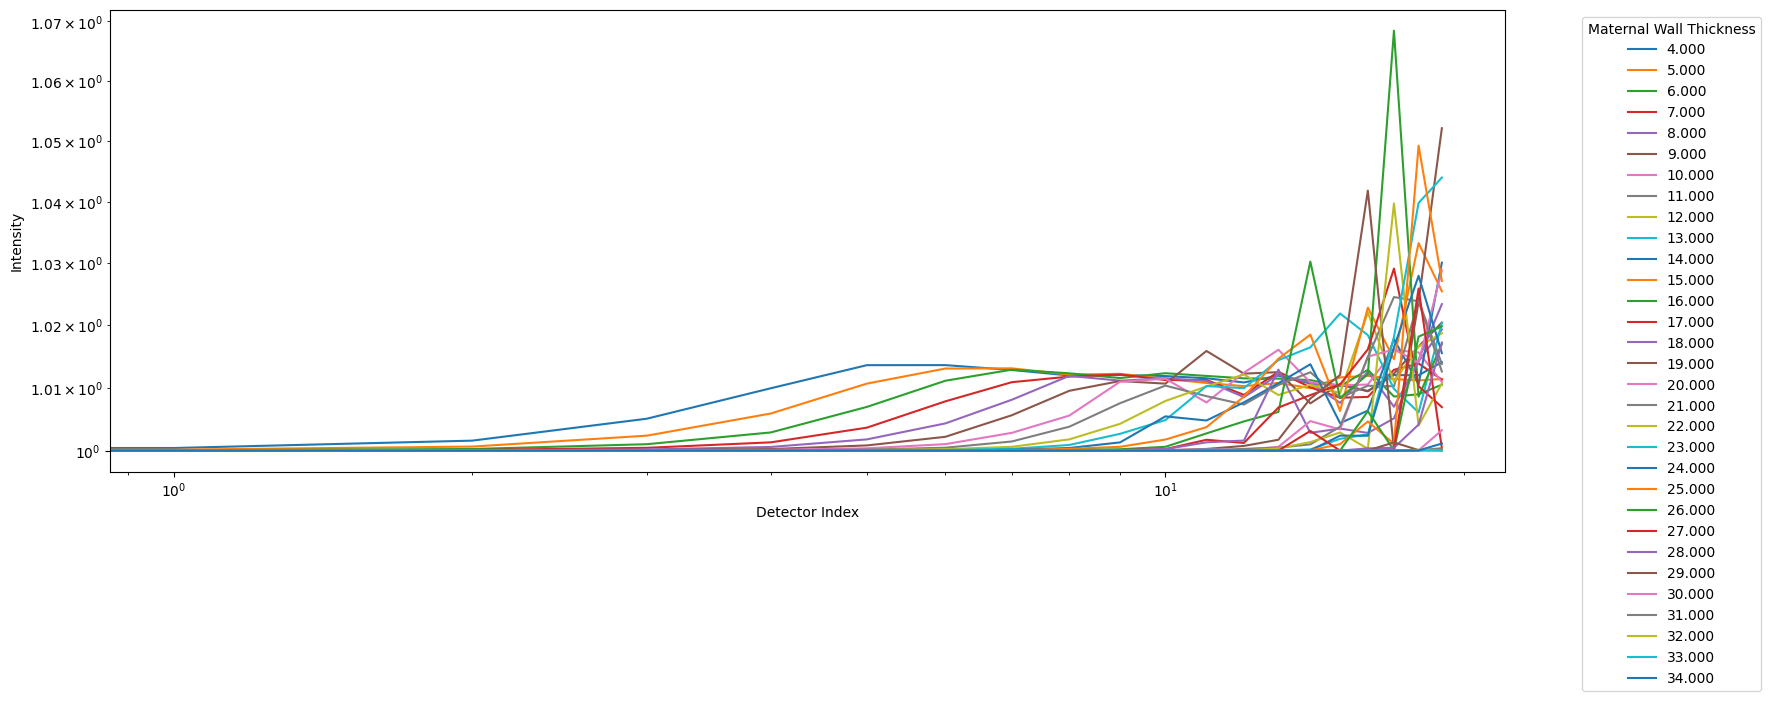

In [5]:
default_values = {        # Contains the default values for the 5 TMPs
    "Maternal Wall Thickness": 28,
    "Maternal Hb Concentration": 14.0,
    "Maternal Saturation": 0.9,
    "Fetal Hb Concentration 2": 15.0,       # 1 has weird values
    "Fetal Saturation": 0.2,
}

# plot_single_tmp_change(pr_data, "Maternal Wall Thickness", pr_columns[:len(pr_columns) // 2], default_dict, (18, 6))
plot_single_tmp_change(pr_data, "Maternal Wall Thickness", new_features[len(new_features) // 2:], default_values, (18, 6))
plt.ylabel("Intensity")
plt.xlabel("Detector Index")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [6]:
import numpy as np


def plot_dual_tmp_matrix(
    data: pd.DataFrame,
    tracked_value: str,
    tmp1: str,
    tmp2: str,
    default_dict: Dict[str, Any] = default_dict,
    fig_size: Tuple[float, float] = (12, 12),
) -> Figure:
    """
    Plot a 2D matrix showing the change in tracked_value  with respect to two seprate TMPs.
    :param data: The dataframe containing the data in a long format
    :param tracked_value: The value to be tracked on the matrix
    :param tmp1: The first TMP to be used as the x-axis
    :param tmp2: The second TMP to be used as the y-axis
    :param default_dict: The default values for the rest of the columns
    :param fig_size: The size of the figure
    """
    # Sanity Check
    assert all(
        [column_name in data.columns for column_name in default_dict.keys()]
    ), "Unknown column(s) in default_dict"
    assert tracked_value in data.columns, "Unknown column as tracked_value"
    assert tmp1 in data.columns, "Unknown column as tmp1"
    assert tmp2 in data.columns, "Unknown column as tmp2"

    # Filter Step
    ## Remove tmp1, tmp2 and tracked_value from the default_dict
    default_dict_filtered = {key: default_dict[key] for key in default_dict if key not in [tmp1, tmp2, tracked_value]}
    ## Filter the data based on the default_dict_filtered
    filtered_data = data.copy()
    for key, value in default_dict_filtered.items():
        filtered_data = filtered_data[filtered_data[key] == value]
        if filtered_data.shape[0] == 0:
            raise ValueError(f"Filtering Breaks for {key} = {value}")

    # Plotting Step
    ## Define the Axes
    fig = plt.figure(figsize=fig_size)
    x_axes = data[tmp1].unique()
    x_axes.sort()
    y_axes = data[tmp2].unique()
    y_axes.sort()
    ## Create the 2D Matrix
    matrix = np.zeros((len(y_axes), len(x_axes)))
    for i, x_value in enumerate(x_axes):
        for j, y_value in enumerate(y_axes):
            temp_data = filtered_data[(filtered_data[tmp1] == x_value) & (filtered_data[tmp2] == y_value)][
                tracked_value
            ].to_numpy()[0]
            matrix[j, i] = temp_data

    ## Plot the Matrix
    plt.imshow(matrix, cmap="viridis", origin="lower", extent=[x_axes[0], x_axes[-1], y_axes[0], y_axes[-1]], aspect="auto")
    plt.xlabel(tmp1)
    plt.ylabel(tmp2)
    plt.colorbar()
    return fig

In [7]:
# Test it out
# plot_dual_tmp_matrix(pr_data, pr_columns[12], "Maternal Wall Thickness", "Fetal Saturation", default_dict)
# plt.show()